# Notebook: SFT Warm-Up for Qwen3-4B-Base (LoRA)

This notebook performs a conservative supervised fine-tuning (SFT) pass to teach the Qwen3-4B base model a strict output schema (format grounding) using LoRA adapters. Key goals, steps, and artifacts:

## Purpose
- Train only formatting/response behavior (not task memorization).
- Produce LoRA adapters for later GRPO training; do not modify or save full model weights.

## Model and Tokenizer
- Base model: `unsloth/Qwen3-4B-Base`.
- Key constants:
    - MAX_SEQ_LENGTH = 3072
    - LORA_RANK = 32
- Attached LoRA adapters via `FastLanguageModel.get_peft_model` targeting attention and MLP projections with `r = 32`, `lora_alpha = 64`, gradient checkpointing enabled.
- Converted tokenizer to ChatML template via `get_chat_template(..., chat_template="chatml", map_eos_token=True)` to enforce Qwen chat formatting.

## Data
- Input dataset: `data/distilled_sft.jsonl` loaded with `datasets.load_dataset("json", ...)`.
- Expected dataset size: 100 examples (asserts in notebook).
- Each sample contains `prompt` and `assistant` fields.

## Training Text Construction
- System prompt (SYSTEM_PROMPT) enforces exact output schema:
    - <START_WORKING_OUT> ... </END_WORKING_OUT>
    - <SOLUTION> Python code only. </SOLUTION>
- `format_example` converts (prompt, assistant) into ChatML-formatted text using `tokenizer.apply_chat_template(...)` and stores it in `"text"`.

## Masking Strategy (Critical)
- Observed that raw tokenization yields labels for prompt/system tokens (not masked by default).
- To ensure loss is computed only on assistant-generated tokens, the helper `train_on_responses_only(trainer, instruction_part=..., response_part=...)` is applied. This sets labels = -100 for system/user/instruction tokens and keeps labels for assistant tokens only — preventing gradient contributions from the prompt.

## Trainer Configuration (SFT)
- Two trainer instantiations used (initial inspection and final run). Final SFT config highlights:
    - per_device_train_batch_size = 2
    - gradient_accumulation_steps = 4
    - max_steps = 60
    - warmup_steps = 5
    - learning_rate = 2e-4
    - optim = "adamw_8bit"
    - weight_decay = 0.001
    - lr_scheduler_type = "linear"
    - precision: bf16 if supported else fp16
    - logging_steps = 1, seed = 42, output_dir = "outputs"
- Trainer bound to `model`, `tokenizer`, and the formatted `dataset` (`dataset_text_field="text"`).

## Important Files & Variables
- MODEL_NAME = "unsloth/Qwen3-4B-Base"
- DATA_PATH = "data/distilled_sft.jsonl"
- MODEL_OUT = "models/qwen3-4b-sft"
- SYSTEM_PROMPT defines required schema for model outputs.

Notes:
- This SFT run focuses exclusively on format grounding; LoRA adapters (small footprint) are the only trained artifacts.
- Masking assistant-only tokens is essential to avoid teaching the model to reproduce prompts or system text.

# Step 1: Mounting Google Drive and Importing Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/grpo-verified-reasoner
!ls

Mounted at /content/drive
/content/drive/MyDrive/grpo-verified-reasoner
data			      LICENSE  notebooks  src
huggingface_tokenizers_cache  models   README.md  unsloth_compiled_cache


In [ ]:
!pip install -q unsloth

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from unsloth import FastLanguageModel
from trl import SFTTrainer, SFTConfig
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only

In [ ]:
os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

# Step 2: Verifying GPU and Environment

In [ ]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


# Step 3: Loading the Base Qwen3 Model

In [ ]:
MODEL_NAME = "unsloth/Qwen3-4B-Base"
MAX_SEQ_LENGTH = 3072
LORA_RANK = 32

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,
    max_seq_length = MAX_SEQ_LENGTH,
    load_in_4bit = False,      # Use 16-bit LoRA (more stable for training)
    fast_inference = False,    # We are training, not serving
)

==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

In [ ]:
# Attach LoRA adapters to the base model for parameter-efficient fine-tuning.
# r: LoRA rank (low-rank factor).
# target_modules: modules to modify (attention projections + MLP gate/up/down).
# lora_alpha: scaling factor for LoRA updates (usually r * 2).
# use_gradient_checkpointing: use unsloth's checkpointing to reduce memory during training.
# random_state: deterministic LoRA initialization.
model = FastLanguageModel.get_peft_model(
    model,
    r = LORA_RANK,
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = LORA_RANK * 2,
    use_gradient_checkpointing = "unsloth",
    random_state = 42,
)

Unsloth: Already have LoRA adapters! We shall skip this step.


In [ ]:
# Attach ChatML template to the tokenizer for Qwen3 chat formatting.
# Uses Qwen ChatML to structure messages; ensures model input/output follow the chat schema.
# map_eos_token=True maps the tokenizer's EOS to the template's end marker so generations terminate cleanly.
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",   # ChatML for Qwen3
    map_eos_token = True,       # Safe default
)

# Step 4: Loading the Distillation Dataset

In [ ]:
DATA_PATH = "data/distilled_sft.jsonl"
dataset = load_dataset("json", data_files=DATA_PATH, split="train")

print(f"Loaded {len(dataset)} SFT samples.")

Loaded 100 SFT samples.


In [ ]:
# Basic sanity checks
assert len(dataset) == 100, "Expected exactly 100 samples."
assert "prompt" in dataset.column_names
assert "assistant" in dataset.column_names

In [ ]:
# Inspect one example
example = dataset[0]
print("\nExample prompt:\n")
print(example["prompt"])


Example prompt:

Write a function to convert a date of yyyy-mm-dd format to dd-mm-yyyy format.


In [ ]:
print("\nExample assistant output:\n")
print(example["assistant"])


Example assistant output:

<START_WORKING_OUT>
Split input string by '-' delimiter.
Assign parts to year, month, day variables.
Return string in format day-month-year joined by '-'.
</END_WORKING_OUT>
<SOLUTION>
def convert_date(date_str):
    year, month, day = date_str.split('-')
    return f"{day}-{month}-{year}"
</SOLUTION>


# Step 5: Build Chat-Formatted Training Text

In [ ]:
SYSTEM_PROMPT = """You are a code-generation engine.

You must output your response in the following exact format:

<START_WORKING_OUT>
Concise reasoning steps required to solve the problem.
</END_WORKING_OUT>
<SOLUTION>
Valid Python code only.
</SOLUTION>

Do not output anything outside these tags.
"""

In [ ]:
def format_example(example):
    """
    Convert a (prompt, assistant) pair into a chat-formatted text string.
    """
    # Build ChatML-style message list expected by the tokenizer template
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["assistant"]},
    ]

    # Render messages to a single string using the Qwen chat template.
    # tokenize=False -> return raw string (not token ids).
    # add_generation_prompt=False -> do not append a generation prompt for decoding.
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,
    )

    # Return as dict to let dataset.map store into "text" column.
    return {"text": text}

In [ ]:
# Apply formatting to entire dataset
dataset = dataset.map(format_example, remove_columns=dataset.column_names)

print("\nSample formatted text (truncated):\n")
print(dataset[0]["text"][:800])


Sample formatted text (truncated):

<|im_start|>system
You are a code-generation engine.

You must output your response in the following exact format:

<START_WORKING_OUT>
Concise reasoning steps required to solve the problem.
</END_WORKING_OUT>
<SOLUTION>
Valid Python code only.
</SOLUTION>

Do not output anything outside these tags.
<|im_end|>
<|im_start|>user
Write a function to convert a date of yyyy-mm-dd format to dd-mm-yyyy format.<|im_end|>
<|im_start|>assistant
<START_WORKING_OUT>
Split input string by '-' delimiter.
Assign parts to year, month, day variables.
Return string in format day-month-year joined by '-'.
</END_WORKING_OUT>
<SOLUTION>
def convert_date(date_str):
    year, month, day = date_str.split('-')
    return f"{day}-{month}-{year}"
</SOLUTION><|im_end|>



In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 100
})

In [ ]:
# Configure SFTTrainer: bind model, tokenizer, and dataset for supervised fine-tuning.
# Keep dataset_text_field pointing to the "text" column produced earlier.
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text", # column containing chat-formatted training strings
    max_seq_length = MAX_SEQ_LENGTH, # model's context length (3072)
    dataset_num_proc = 2, # parallelism for dataset preprocessing/mapping
    packing = False, # disable packing multiple examples into one sequence
    args = SFTConfig(
        per_device_train_batch_size = 2, # batch per GPU
        gradient_accumulation_steps = 4, # accumulate to achieve effective batch size
        warmup_steps = 5, # linear warmup steps
        num_train_epochs = 3, # small dataset: multiple epochs for format learning
        learning_rate = 2e-4, # base LR for LoRA fine-tuning
        logging_steps = 1, # log frequently for monitoring on small runs
        optim = "adamw_8bit", # memory-efficient optimizer
        weight_decay = 0.01, # regularization
        lr_scheduler_type = "linear", # LR schedule
        seed = 3407, # reproducibility
        output_dir = "outputs", # checkpoint/output dir
        report_to = "none", # disable external logging integrations
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=12):   0%|          | 0/100 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


# Step 6: Performing Unit Test to Inspect Masking Behaviour

In [ ]:
# Take a single formatted example
sample = dataset[0]["text"]

print("=== RAW TEXT ===")
print(sample)

=== RAW TEXT ===
<|im_start|>system
You are a code-generation engine.

You must output your response in the following exact format:

<START_WORKING_OUT>
Concise reasoning steps required to solve the problem.
</END_WORKING_OUT>
<SOLUTION>
Valid Python code only.
</SOLUTION>

Do not output anything outside these tags.
<|im_end|>
<|im_start|>user
Write a function to convert a date of yyyy-mm-dd format to dd-mm-yyyy format.<|im_end|>
<|im_start|>assistant
<START_WORKING_OUT>
Split input string by '-' delimiter.
Assign parts to year, month, day variables.
Return string in format day-month-year joined by '-'.
</END_WORKING_OUT>
<SOLUTION>
def convert_date(date_str):
    year, month, day = date_str.split('-')
    return f"{day}-{month}-{year}"
</SOLUTION><|im_end|>



In [ ]:
# Tokenize exactly how the trainer will
encoded = tokenizer(
    sample,
    return_tensors="pt",
)

input_ids = encoded["input_ids"][0]

In [ ]:
# Simulate default CLM labels (what SFTTrainer uses internally)
labels = input_ids.clone()

In [ ]:
# Decode tokens + labels side by side for first N tokens
N = 80
print("Idx | Token | Label")
print("-" * 40)

for i in range(N):
    token_str = tokenizer.decode(input_ids[i])
    label_val = labels[i].item()
    print(f"{i:>3} | {repr(token_str):>12} | {label_val}")

Idx | Token | Label
----------------------------------------
  0 | '<|im_start|>' | 151644
  1 |     'system' | 8948
  2 |         '\n' | 198
  3 |        'You' | 2610
  4 |       ' are' | 525
  5 |         ' a' | 264
  6 |      ' code' | 2038
  7 | '-generation' | 42827
  8 |    ' engine' | 4712
  9 |      '.\n\n' | 382
 10 |        'You' | 2610
 11 |      ' must' | 1969
 12 |    ' output' | 2550
 13 |      ' your' | 697
 14 |  ' response' | 2033
 15 |        ' in' | 304
 16 |       ' the' | 279
 17 | ' following' | 2701
 18 |     ' exact' | 4734
 19 |    ' format' | 3561
 20 |      ':\n\n' | 1447
 21 |          '<' | 27
 22 |      'START' | 22564
 23 |      '_WORK' | 34044
 24 |        'ING' | 1718
 25 |       '_OUT' | 11881
 26 |        '>\n' | 397
 27 |        'Con' | 1109
 28 |          'c' | 66
 29 |        'ise' | 1064
 30 | ' reasoning' | 32711
 31 |     ' steps' | 7354
 32 |  ' required' | 2567
 33 |        ' to' | 311
 34 |     ' solve' | 11625
 35 |       ' the' | 279
 36 | 

As you can see, the tokens for the system prompt and the question is not masked (does not have a value of -100). That means that if we were to run the SFT with our dataset as it is, the model would start computing gradients using the tokens for the prompt and question, which is something we want to avoid. We want the model to see and be trained on ONLY the solution generated.

# Step 7: Training

In [ ]:
MODEL_OUT = "models/qwen3-4b-sft"

In [ ]:
# Configure SFTTrainer: bind model, tokenizer, and dataset for supervised fine-tuning.
# Keeps dataset_text_field pointing to the "text" column produced earlier.
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    args = SFTConfig(
        # Core training signal
        per_device_train_batch_size = 2,        # micro-batch per GPU
        gradient_accumulation_steps = 4,        # accumulate to increase effective batch size
        max_steps = 60,                         # total optimization steps (limits epochs)
        warmup_steps = 5,                       # linear warmup period

        # Optimization
        learning_rate = 2e-4,                   # LoRA learning rate
        optim = "adamw_8bit",                   # memory-efficient optimizer
        weight_decay = 0.001,                   # regularization
        lr_scheduler_type = "linear",           # LR schedule

        # Precision (choose bf16 on supported hardware, else fp16)
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),

        # Bookkeeping / logging / reproducibility
        logging_steps = 1,                      # log frequently for small runs
        seed = 42,                              # deterministic runs
        output_dir = "outputs",                 # checkpoint / adapter dump
        report_to = "none",                     # disable external telemetry
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=12):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Mask training loss so only assistant-generated tokens contribute.
# train_on_responses_only sets labels=-100 for system/user/instruction tokens
# and keeps labels for assistant tokens, preventing penalization for the prompt.
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part    = "<|im_start|>assistant\n",
)

Map (num_proc=12):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 5 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.744700
2,0.771100
3,0.662000
4,0.616700
5,0.548300
6,0.557300
7,0.503600
8,0.739700
9,0.480600
10,0.639100


TrainOutput(global_step=60, training_loss=0.3006189752370119, metrics={'train_runtime': 231.9695, 'train_samples_per_second': 2.069, 'train_steps_per_second': 0.259, 'total_flos': 3250414559428608.0, 'train_loss': 0.3006189752370119, 'epoch': 4.64})

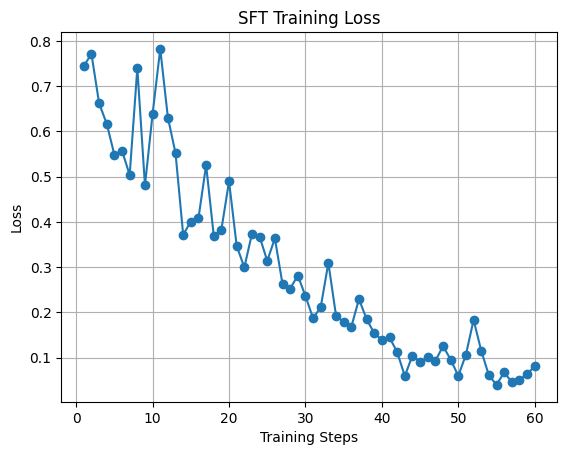

In [ ]:
logs = trainer.state.log_history

steps = [x["step"] for x in logs if "loss" in x]
losses = [x["loss"] for x in logs if "loss" in x]

plt.plot(steps, losses, marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("SFT Training Loss")
plt.grid(True)
plt.show()

Sharp convergence within 100 steps indicates rapid schema acquisition without overfitting. Final loss stabilized at ~0.1, confirming successful format adaptation.

# Step 8: Sanity Check

In [ ]:
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 2560, padding_idx=151654)
        (layers): ModuleList(
          (0-35): 36 x Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2560, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

In [ ]:
test_cases = [
    # 1. Simple Algorithm (String manipulation)
    "Write a function to check if a string is a palindrome.",

    # 2. Math/Logic (Requires step-by-step reasoning)
    "Write a function to calculate the factorial of a number using recursion.",

    # 3. Data Structure (Slightly more complex)
    "Write a function to merge two sorted lists into one sorted list."
]

In [ ]:
# Iterate over test cases and run the model in inference mode
for i, prompt in enumerate(test_cases):
    # Build ChatML-style messages: system context + user query
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
    ]

    # Tokenize messages, return tensors and include generation prompt for decoding
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    )
    # Move tensors to GPU
    inputs = {k: v.to("cuda") for k, v in inputs.items()}
    # Record input length to extract only newly generated tokens later
    input_len = inputs["input_ids"].shape[1]

    # Inference without gradient tracking
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.0, # deterministic decoding for tests
            do_sample=False,
        )
    # Slice off the prompt tokens to keep only generated continuation
    generated_tokens = output[0][input_len:]
    # Decode generated tokens to text, skipping special tokens
    decoded = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # Print tidy test output
    print(f"TEST CASE {i+1}: {prompt}")
    print("-" * 40)
    print(decoded)
    print("\n" + "="*40 + "\n")

TEST CASE 1: Write a function to check if a string is a palindrome.
----------------------------------------
<START_WORKING_OUT>
Define function is_palindrome(s) that checks if string s reads the same forwards and backwards.
Convert to lowercase and remove non-alphanumeric characters for case-insensitive comparison.
Compare the string with its reverse.
Return True if equal, else False.
</END_WORKING_OUT>
<SOLUTION>
import re

def is_palindrome(s: str) -> bool:
    """
    Check if the given string is a palindrome.
    
    Args:
        s (str): The string to check.
    
    Returns:
        bool: True if the string is a palindrome, False otherwise.
    """
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned = re.sub(r'[^a-zA-Z0-9]', '', s).lower()
    # Compare with reversed string
    return cleaned == cleaned[::-1]
</SOLUTION>


TEST CASE 2: Write a function to calculate the factorial of a number using recursion.
----------------------------------------
<ST

# Step 9: Saving the Model

In [ ]:
model.save_pretrained(MODEL_OUT)

In [ ]:
tokenizer.save_pretrained(MODEL_OUT)

('models/qwen3-4b-sft/tokenizer_config.json',
 'models/qwen3-4b-sft/special_tokens_map.json',
 'models/qwen3-4b-sft/chat_template.jinja',
 'models/qwen3-4b-sft/vocab.json',
 'models/qwen3-4b-sft/merges.txt',
 'models/qwen3-4b-sft/added_tokens.json',
 'models/qwen3-4b-sft/tokenizer.json')

# Step 6: Fixing Metadata

In [ ]:
import nbformat
import os

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

In [5]:
# List the notebook directory to confirm the file exists
os.listdir("/content/drive/MyDrive/grpo-verified-reasoner/notebooks")

['.gitkeep',
 '00_environment_sanity_check.ipynb',
 '01_distillation_dataset.ipynb',
 '02_qwen3_4B_sft.ipynb']

In [6]:
notebook_path = "/content/drive/MyDrive/grpo-verified-reasoner/notebooks/02_qwen3_4B_sft.ipynb"

with open(notebook_path, "r") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

with open(notebook_path, "w") as f:
    nbformat.write(nb, f)

print("Notebook fixed and saved successfully!")

Notebook fixed and saved successfully!
